In [5]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import os

# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 置放訓練資料的目錄
DATA_PATH = os.path.join(ROOT_DIR, "dataSet\machineTranslation")

# 訓練資料檔
DATA_FILE = os.path.join(DATA_PATH, "cmn-tw.txt")



In [6]:
DATA_FILE

'c:\\Users\\xdxd2\\Sunny_VS_worksapce\\Sunny_python\\NLP\\iSpan_python-NLP-cookbooks\\04_茅舍頓開\\dataSet\\machineTranslation\\cmn-tw.txt'

In [7]:
batch_size = 64 # 訓練時的批次數量
epochs = 100 # 訓練循環數
latent_dim = 256 # 編碼後的潛在空間的維度(dimensions of latent space)
num_samples = 10000 # 用來訓練的樣本數

# 資料向量化
input_texts = []
target_texts = []
input_characters = set() # 英文字符集
target_characters = set() # 中文字符集
lines = open(DATA_FILE, mode="r", encoding="utf-8").read().split('\n')

# 逐行的讀取與處理
for line in lines[: min(num_samples, len(lines)-1)]:
    input_text, target_text = line.split('\t')
    
    # 我們使用“tab”作為“開始序列[SOS]”字符或目標，“\n”作為“結束序列[EOS]”字符。 <-- **重要
    target_text = '\t' + target_text + '\n'
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [8]:
input_characters = sorted(list(input_characters)) # 全部輸入的字符集
target_characters = sorted(list(target_characters)) # 全部目標字符集

num_encoder_tokens = len(input_characters) # 所有輸入字符的數量
num_decoder_tokens = len(target_characters) # 所有輸出目標字符的數量

max_encoder_seq_length = max([len(txt) for txt in input_texts]) # 最長的輸入句子長度
max_decoder_seq_length = max([len(txt) for txt in target_texts]) # 最長的目標句子長度

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)


Number of samples: 10000
Number of unique input tokens: 73
Number of unique output tokens: 2165
Max sequence length for inputs: 33
Max sequence length for outputs: 22


In [9]:
# 輸入字符的索引字典
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])

# 輸目標字符的索引字典
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

# 包含英文句子的one-hot向量化的三維形狀數組（num_pairs，max_english_sentence_length，num_english_characters）
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')

# 包含中文句子的one-hot向量化的三維形狀數組（num_pairs，max_chinese_sentence_length，num_chinese_characters）
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# decoder_target_data與decoder_input_data相同，但是偏移了一個時間步長。 
# decoder_target_data [:, t，：]將與decoder_input_data [：，t + 1，：]相同
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# 把資料轉換成要用來訓練用的張量資料結構 <-- 重要
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
        
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

## 模型訓練

In [10]:
# ===== 編碼 (encoder) ====

# 定義輸入的序列
# 注意：因為輸入序列長度(timesteps)可變的情況，使用input_shape =（None，num_features）
encoder_inputs = Input(shape=(None, num_encoder_tokens), name='encoder_input') 
encoder = LSTM(latent_dim, return_state=True, name='encoder_lstm') # 需要取得LSTM的內部state, 因此設定"return_state=True"
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# 我們拋棄掉`encoder_outputs`因為我們只需要LSTM cell的內部state參數
encoder_states = [state_h, state_c]

# ==== 解碼 (decoder) ====

# 設定解碼器(decoder)
# 注意：因為輸出序列的長度(timesteps)是變動的，使用input_shape =（None，num_features）
decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_input')

# 我們設定我們的解碼器回傳整個輸出的序列同時也回傳內部的states參數
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')

# 在訓練時我們不會使用這些回傳的states, 但是在預測時我們會用到這些states參數
# **解碼器的初始狀態是使用編碼器的最後的狀態(states)**
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states) #我們使用`encoder_states`來做為初始值(initial state) <-- 重要

# 接密集層(dense)來進行softmax運算每一個字符可能的機率
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_output')
decoder_outputs = decoder_dense(decoder_outputs)

# 定義一個模型接收encoder_input_data` & `decoder_input_data`做為輸入而輸出`decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 打印出模型結構
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, None, 73)]           0         []                            
                                                                                                  
 decoder_input (InputLayer)  [(None, None, 2165)]         0         []                            
                                                                                                  
 encoder_lstm (LSTM)         [(None, 256),                337920    ['encoder_input[0][0]']       
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

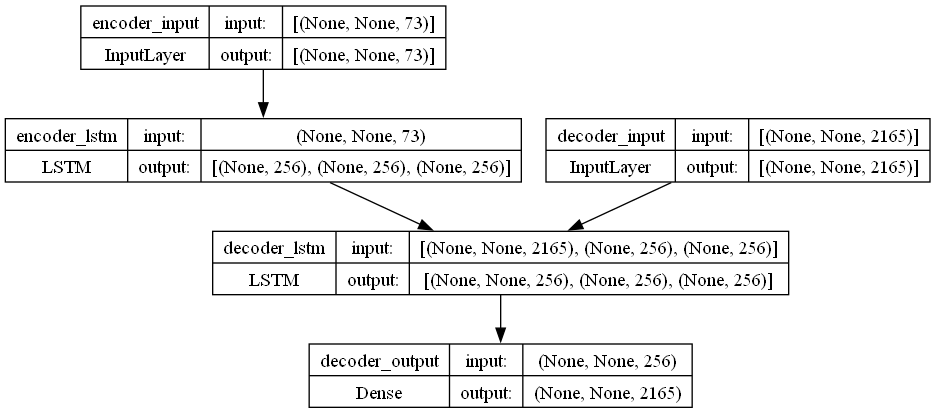

In [11]:
from keras.utils import plot_model
from IPython.display import Image

# 產生網絡拓撲圖
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)


In [12]:
# 設定模型超參數
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# 開始訓練
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

# 儲存模型
model.save('s2s.h5')

Epoch 1/100
125/125 [==============================] - 64s 473ms/step - loss: 2.2322 - val_loss: 2.5843
Epoch 2/100
125/125 [==============================] - 53s 424ms/step - loss: 2.0347 - val_loss: 2.6267
Epoch 3/100
125/125 [==============================] - 54s 432ms/step - loss: 2.0265 - val_loss: 2.6143
Epoch 4/100
114/125 [==========================>...] - ETA: 1:04 - loss: 2.0374

In [ ]:
# 定義要進行取樣的模型

# 定義編碼器(encoder)的模型
encoder_model = Model(encoder_inputs, encoder_states)

# 定義解碼器LSTM cell的初始權重輸入
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# # 解碼器(decoder)定義初始狀態(initial decoder state)
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs) #我們使用`decoder_states_inputs`來做為初始值(initial state)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

# 定義解碼器(decoder)的模型
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)


# 反向查找字符索引來將序列解碼為可讀的內容。
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())

reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

# 對序列進行解碼
def decode_sequence(input_seq):
    # 將輸入編碼成為state向量
    states_value = encoder_model.predict(input_seq)
    
    # 產生長度為1的空白目標序列
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    # 發佈特定的目標序列起始字符"[SOS]",在這個範例中是使用 "\t"字符
    target_seq[0, 0, target_token_index['\t']] = 1.

    # 對批次的序列進行抽樣迴圈
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # 對符標抽樣
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # 停止迴圈的條件: 到達最大的長度或是找到"停止[EOS]"字符,在這個範例中是使用 "\n"字符
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # 更新目標序列(of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # 更新 states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100,120):
    # 從訓練集中取出一個序列並試著解碼
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

1/1 [==============================] - 0s 458ms/step
[[[1.0229140e-12 1.0523190e-09 5.3797886e-09 ... 6.5692788e-05
   1.6322971e-08 4.2083786e-10]]]
1/1 [==============================] - 0s 29ms/step
[[[8.7930586e-11 3.0096783e-06 2.3948428e-06 ... 2.9511859e-05
   3.5051890e-08 2.8362413e-07]]]
1/1 [==============================] - 0s 25ms/step
[[[8.6536041e-08 3.0687610e-02 2.0449285e-03 ... 6.5487623e-04
   3.4284210e-07 4.9827797e-03]]]
1/1 [==============================] - 0s 24ms/step
[[[1.3444798e-06 8.2308032e-02 1.7654890e-03 ... 1.7728317e-03
   1.1589041e-05 1.1825795e-02]]]
-
Input sentence: Try some.
Decoded sentence: 試試。

1/1 [==============================] - 0s 28ms/step
[[[4.4501334e-12 2.5183104e-09 1.7989316e-09 ... 2.4767473e-06
   2.7892082e-08 2.2627713e-08]]]
1/1 [==============================] - 0s 25ms/step
[[[2.4794031e-09 1.5398520e-05 1.4877058e-06 ... 1.2535729e-05
   1.1376044e-06 5.4933422e-05]]]
1/1 [==============================] - 0s 27ms/step
[[